# FACE_MASK_DETECTION

TEAM 7

1. Maimuna Bashir
2. Ahmed Ibrahim Ahmed
3. Kwabena (Kobe) Mensah

In [ ]:
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = ('/content/drive/MyDrive/annotations')

In [ ]:
image_path= ('/content/drive/MyDrive/images')

In [ ]:
# Function to parse an XML file and extract annotations
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        label = member.find('name').text
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        annotations.append({'label': label, 'bbox': [xmin, ymin, xmax, ymax]})

    filename = root.find('filename').text
    return filename, annotations

In [ ]:
# Function to preprocess a single image and its annotations for a fixed size of 300x300
def preprocess_image_annotation(image_path, annotation_list, target_size=(300, 300)):
    # Load the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Original size
    original_size = image.size

    # Resize image to 600x600
    image = image.resize(target_size)

    # Normalize the pixel values to be between 0 and 1
    image_array = np.array(image) / 255.0

    # Scale the bounding box annotations
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]
    scaled_annotations = []
    for ann in annotation_list:
        scaled_bbox = [int(ann['bbox'][0] * scale_x), int(ann['bbox'][1] * scale_y),
                       int(ann['bbox'][2] * scale_x), int(ann['bbox'][3] * scale_y)]
        scaled_annotations.append({'label': ann['label'], 'bbox': scaled_bbox})

    return image_array, scaled_annotations

In [ ]:
# Paths to the annotations and images folders
annotations_dir = ('/content/drive/MyDrive/annotations')
images_dir = ('/content/drive/MyDrive/images')


In [ ]:
# List all XML files in the annotations directory
xml_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]

In [ ]:
# Preprocess all images and annotations
preprocessed_data = []
for xml_file in xml_files:
    # Parse annotations
    filename, annotations = parse_xml(os.path.join(annotations_dir, xml_file))

    # Corresponding image path
    image_filename = filename.replace('.xml', '.png')  # Ensure the extension matches your image files
    image_path = os.path.join(images_dir, image_filename)

    # Preprocess image and annotations
    image_array, scaled_annotations = preprocess_image_annotation(image_path, annotations)

    # Store in the list
    preprocessed_data.append({'image': image_array, 'annotations': scaled_annotations})


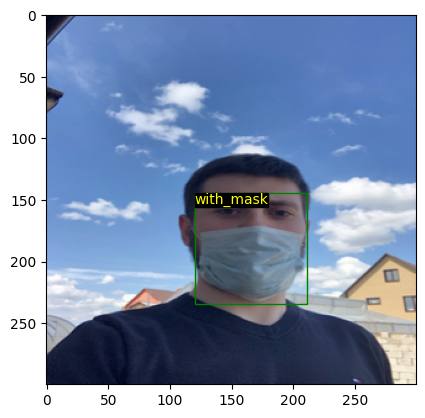

In [ ]:
# Visualize one example
sample_image_data = preprocessed_data[0]['image']
sample_annotations = preprocessed_data[0]['annotations']
plt.imshow(sample_image_data)
for ann in sample_annotations:
    bbox = ann['bbox']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             linewidth=1, edgecolor='r' if ann['label'] == 'without_mask' else 'g',
                             facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(bbox[0], bbox[1], ann['label'], color='yellow', verticalalignment='top',
             bbox={'color': 'black', 'pad': 0})
plt.show()

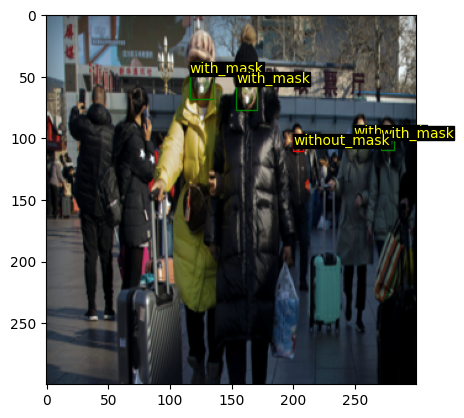

In [ ]:
# Visualize one example
sample_image_data = preprocessed_data[2]['image']
sample_annotations = preprocessed_data[2]['annotations']
plt.imshow(sample_image_data)
for ann in sample_annotations:
    bbox = ann['bbox']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             linewidth=1, edgecolor='r' if ann['label'] == 'without_mask' else 'g',
                             facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(bbox[0], bbox[1], ann['label'], color='yellow', verticalalignment='top',
             bbox={'color': 'black', 'pad': 0})
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Convert annotations to a suitable format for model training (e.g., one-hot encoding for labels)
labels = []
for data in preprocessed_data:
    # Example: Convert labels to one-hot encoded format
    # Modify this based on how you want to handle labels
    labels.append(1 if 'without_mask' in [ann['label'] for ann in data['annotations']] else 0)

In [ ]:
# Prepare features and labels for the model
features = [data['image'] for data in preprocessed_data]
features = np.array(features)
labels = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [ ]:
# Load a pre-trained VGG16 model as a base
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # Freeze the base model layers

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Create the model
model = Sequential([
    base_model,  # This is your pre-trained base model
    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.5),

    # Additional dense layer (optional)
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # Use 'softmax' for multiclass classification
])

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50  # Adjust the number of epochs based on your requirement
)

Epoch 1/50
22/22 [==============================] - 42s 1s/step - loss: 1.6839 - accuracy: 0.5264 - val_loss: 1.2857 - val_accuracy: 0.7135
Epoch 2/50
22/22 [==============================] - 19s 868ms/step - loss: 1.5141 - accuracy: 0.5572 - val_loss: 1.2586 - val_accuracy: 0.7135
Epoch 3/50
22/22 [==============================] - 21s 968ms/step - loss: 1.5224 - accuracy: 0.5718 - val_loss: 1.2143 - val_accuracy: 0.7076
Epoch 4/50
22/22 [==============================] - 20s 925ms/step - loss: 1.4413 - accuracy: 0.5924 - val_loss: 1.2033 - val_accuracy: 0.6725
Epoch 5/50
22/22 [==============================] - 20s 883ms/step - loss: 1.3864 - accuracy: 0.6158 - val_loss: 1.1903 - val_accuracy: 0.6491
Epoch 6/50
22/22 [==============================] - 21s 945ms/step - loss: 1.3862 - accuracy: 0.6276 - val_loss: 1.1612 - val_accuracy: 0.6842
Epoch 7/50
22/22 [==============================] - 19s 867ms/step - loss: 1.3865 - accuracy: 0.6144 - val_loss: 1.1513 - val_accuracy: 0.7135
Ep

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

6/6 [==============================] - 1s 221ms/step - loss: 1.0555 - accuracy: 0.7427
Test accuracy: 0.7426900863647461


In [ ]:
# Calculate additional performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

6/6 [==============================] - 1s 240ms/step


In [ ]:
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Precision: 0.5538461538461539, Recall: 0.7058823529411765, F1-Score: 0.6206896551724139


In [ ]:
# Path to the image in Colab environment
image_path = '/content/drive/MyDrive/pic2_rgb.jpg'

1/1 [==============================] - 0s 459ms/step


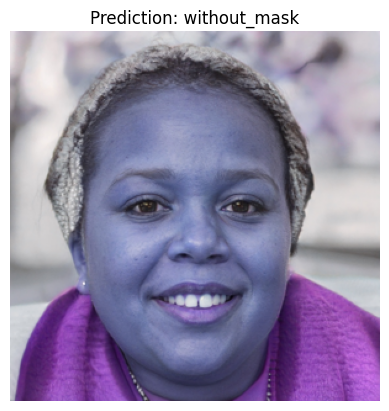

Mask status: without_mask


In [ ]:
def preprocess_and_predict(image_path):
    # Load the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format

    # Preprocess the image
    target_size = (300, 300)
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(image_array)

    # Interpret the prediction
    mask_status = 'without_mask' if prediction[0][0] > 0.5 else 'with_mask'

    # Show the image and prediction
    plt.imshow(np.squeeze(image_array))
    plt.title(f'Prediction: {mask_status}')
    plt.axis('off')
    plt.show()

    return mask_status



# Predict if the person in the image is wearing a mask or not
mask_status = preprocess_and_predict(image_path)
print("Mask status:", mask_status)